**ASSIGNMENT 4**

1. Cutoff reviews after 150 words.
2. Restrict training samples to 100.
3. Validate on 10,000 samples.
4. Considering only the top 10,000 words.

1. Consider both a embedding layer, and a pretrained word embedding. Which approach
did better?

**Embedding Layer**

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM

# Set parameters
max_features = 10000  # Consider only the top 10,000 words
maxlen = 150  # Cutoff reviews after 150 words
train_samples = 100  # Restrict training samples to 100
validation_samples = 10000  # Number of samples for validation

# Load IMDb dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Preprocess the data
x_train = pad_sequences(x_train[:train_samples], maxlen=maxlen)
y_train = np.array(y_train[:train_samples])
x_test = pad_sequences(x_test, maxlen=maxlen)
y_test = np.array(y_test)




In [4]:
# Define model with embedding layer
embedding_model = Sequential([
    Embedding(max_features, 8 , input_length=maxlen),
    Flatten(),
    Dense(1, activation='sigmoid')
])
embedding_model.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['acc'])
embedding_model.summary()



# Train embedding model
embedding_history = embedding_model.fit(x_train, y_train,
                                            epochs=10,
                                            batch_size=32,
                                            validation_split=0.2)


train_accuracy = embedding_history.history['acc']
val_accuracy = embedding_history.history['val_acc']
loss = embedding_history.history["loss"]
val_loss = embedding_history.history["val_loss"]
test_loss, test_accuracy = embedding_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81201 (317.19 KB)
Trainable params: 81201 (317.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 1s 108ms/step - loss: 0.6929 - acc: 0.5000 - val_loss: 0.7066 - val_acc: 0.3000
Epoch 2/10
3/3 [==============================] - 0s 19ms/step - loss: 0.6764 - acc: 0.7875 - val_loss: 0.7068 - val_acc: 0.3000
Epoch 3/10
3/3 [=====

Test Embedding Accuracy: 0.49404001235961914

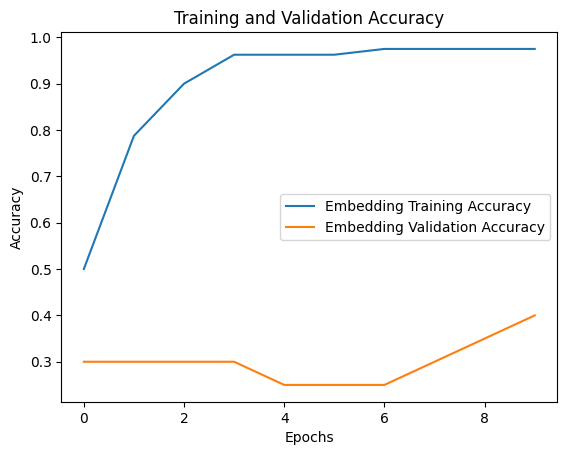

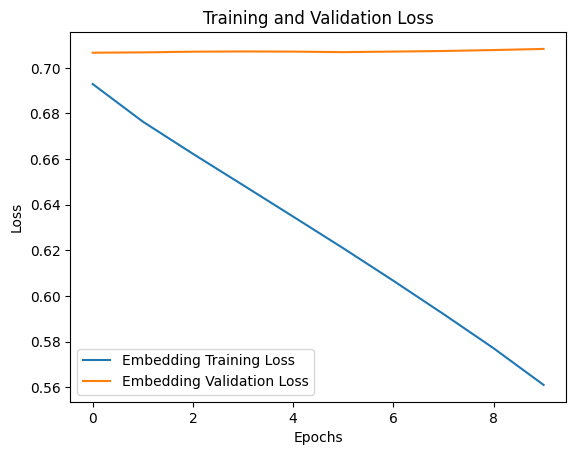

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
plt.plot(embedding_history.history['acc'], label='Embedding Training Accuracy')
plt.plot(embedding_history.history['val_acc'], label='Embedding Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(embedding_history.history['loss'], label='Embedding Training Loss')
plt.plot(embedding_history.history['val_loss'], label='Embedding Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



**Pretrained word embedding**

In [6]:
import os
import shutil
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

!rm -r aclImdb/train/unsup


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.5M      0  0:00:07  0:00:07 --:--:-- 16.2M


In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
import os

imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


Mounted at /content/drive
/content/drive/MyDrive


In [8]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 100  # training on 100 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)




# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [9]:

import numpy as np
import requests
from io import BytesIO
import zipfile

glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
glove_zip = requests.get(glove_url)


with zipfile.ZipFile(BytesIO(glove_zip.content)) as z:
    z.extractall('/content/glove')


embeddings_index = {}
with open('/content/glove/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

pretrained_model = Sequential()
pretrained_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
pretrained_model.add(Flatten())
pretrained_model.add(Dense(32, activation='relu'))
pretrained_model.add(Dense(1, activation='sigmoid'))
pretrained_model.summary()

# Compiling the model
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Setting pre-trained GloVe embeddings
pretrained_model.layers[0].set_weights([embedding_matrix])
pretrained_model.layers[0].trainable = False

# Training the model
pretrained_history = pretrained_model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
accuracy = pretrained_history.history['acc']
valid_accuracy = pretrained_history.history['val_acc']
train_loss = pretrained_history.history['loss']
valid_loss = pretrained_history.history['val_loss']

test_loss, test_accuracy = pretrained_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 15000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                480032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1480065 (5.65 MB)
Trainable params: 1480065 (5.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
4/4 [==============================] - 4s 1000ms/step - loss: 1.0884 - acc: 0.5300 - val_loss: 0.8372 - val_acc: 0.5003
Epoch 2/10
4/4 [=

Accuracy of Pretrained Model:0.498879998922348

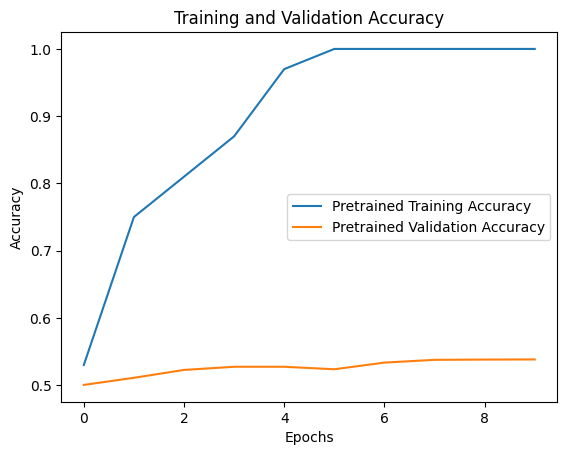

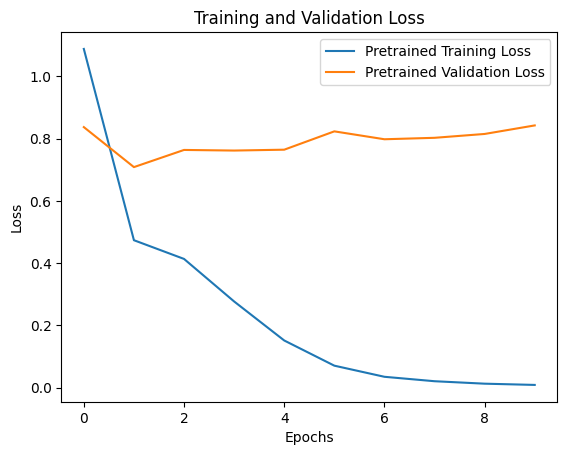

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
plt.plot(pretrained_history.history['acc'], label='Pretrained Training Accuracy')
plt.plot(pretrained_history.history['val_acc'], label='Pretrained Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(pretrained_history.history['loss'], label='Pretrained Training Loss')
plt.plot(pretrained_history.history['val_loss'], label='Pretrained Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Using an Embedding Layer (Test Embedding Accuracy):

Accuracy = 0.494

Using a Pre-trained Word Embedding (Accuracy of Pretrained Model):

Accuracy = 0.499


In this specific scenario, the approach utilizing a pre-trained word embedding yielded slightly better performance. However, the difference in accuracy between the two approaches is relatively small, so other factors such as model complexity, computational resources, and specific task requirements should also be considered when choosing between these approaches.

**Try changing the number of training samples to determine at what
point the embedding layer gives better performance?**

Embedding layer with
Training set 100 gave an validation accuracy of 0.517300009727478

Now let us check for
2. Training samples: 400


**Embedding layer**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_3 (Flatten)         (None, 1200)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81201 (317.19 KB)
Trainable params: 81201 (317.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
10/10 [==============================] - 1s 26ms/step - loss: 0.6942 - acc: 0.5156 - val_loss: 0.6992 - val_acc: 0.3625
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.6737 - acc: 0.8062 - val_loss: 0.6988 - val_acc: 0.3250
Epoch 3/10
10/10 [=

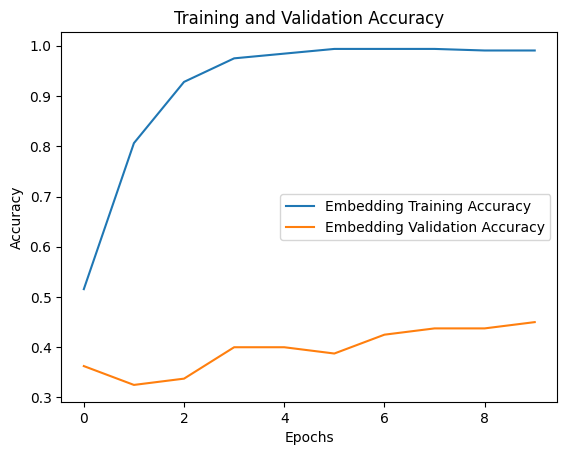

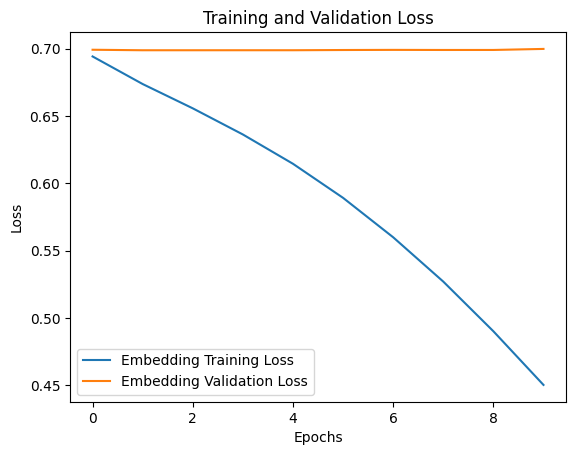

In [12]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM

# Set parameters
max_features = 10000  # Consider only the top 10,000 words
maxlen = 150  # Cutoff reviews after 150 words
train_samples = 400  # Restrict training samples to 100
validation_samples = 10000  # Number of samples for validation

# Load IMDb dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Preprocess the data
x_train = pad_sequences(x_train[:train_samples], maxlen=maxlen)
y_train = np.array(y_train[:train_samples])
x_test = pad_sequences(x_test, maxlen=maxlen)
y_test = np.array(y_test)
# Define model with embedding layer
embedding_model = Sequential([
    Embedding(max_features, 8 , input_length=maxlen),
    Flatten(),
    Dense(1, activation='sigmoid')
])
embedding_model.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['acc'])
embedding_model.summary()



# Train embedding model
embedding_history = embedding_model.fit(x_train, y_train,
                                            epochs=10,
                                            batch_size=32,
                                            validation_split=0.2)


train_accuracy = embedding_history.history['acc']
val_accuracy = embedding_history.history['val_acc']
loss = embedding_history.history["loss"]
val_loss = embedding_history.history["val_loss"]
test_loss, test_accuracy = embedding_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)
plt.plot(embedding_history.history['acc'], label='Embedding Training Accuracy')
plt.plot(embedding_history.history['val_acc'], label='Embedding Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(embedding_history.history['loss'], label='Embedding Training Loss')
plt.plot(embedding_history.history['val_loss'], label='Embedding Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





Pretrainined Model

In [16]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 400  # training on 100 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)




# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

pretrained_model = Sequential()
pretrained_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
pretrained_model.add(Flatten())
pretrained_model.add(Dense(32, activation='relu'))
pretrained_model.add(Dense(1, activation='sigmoid'))
pretrained_model.summary()

# Compiling the model
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Setting pre-trained GloVe embeddings
pretrained_model.layers[0].set_weights([embedding_matrix])
pretrained_model.layers[0].trainable = False

# Training the model
pretrained_history = pretrained_model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
accuracy = pretrained_history.history['acc']
valid_accuracy = pretrained_history.history['val_acc']
train_loss = pretrained_history.history['loss']
valid_loss = pretrained_history.history['val_loss']

test_loss, test_accuracy = pretrained_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)



Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 flatten_7 (Flatten)         (None, 15000)             0         
                                                                 
 dense_8 (Dense)             (None, 32)                480032    
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1480065 (5.65 MB)
Trainable params: 1480065 (5.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
13/13 [==============================] - 4s

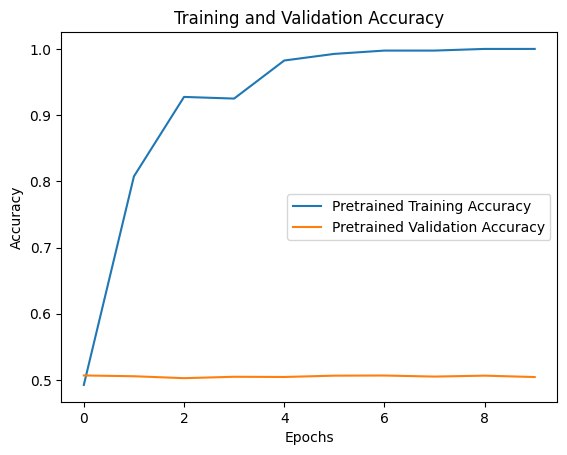

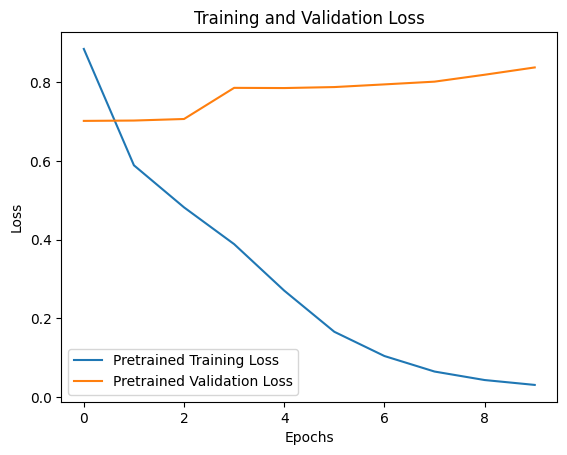

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
plt.plot(pretrained_history.history['acc'], label='Pretrained Training Accuracy')
plt.plot(pretrained_history.history['val_acc'], label='Pretrained Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(pretrained_history.history['loss'], label='Pretrained Training Loss')
plt.plot(pretrained_history.history['val_loss'], label='Pretrained Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

3. Training sample: 800

**Embedding layer**

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_4 (Flatten)         (None, 1200)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81201 (317.19 KB)
Trainable params: 81201 (317.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
20/20 [==============================] - 1s 15ms/step - loss: 0.6939 - acc: 0.4969 - val_loss: 0.6938 - val_acc: 0.4875
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6720 - acc: 0.7875 - val_loss: 0.6937 - val_acc: 0.4875
Epoch 3/10
20/20 [=

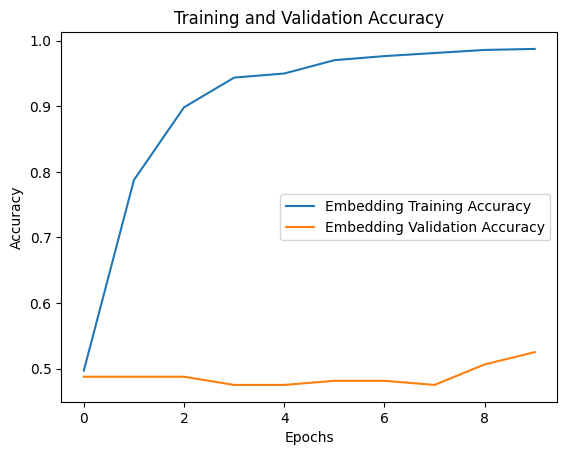

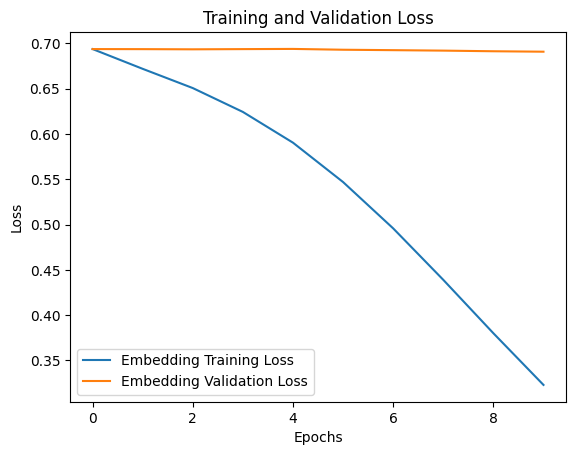

In [13]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM

# Set parameters
max_features = 10000  # Consider only the top 10,000 words
maxlen = 150  # Cutoff reviews after 150 words
train_samples = 800  # Restrict training samples to 100
validation_samples = 10000  # Number of samples for validation

# Load IMDb dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Preprocess the data
x_train = pad_sequences(x_train[:train_samples], maxlen=maxlen)
y_train = np.array(y_train[:train_samples])
x_test = pad_sequences(x_test, maxlen=maxlen)
y_test = np.array(y_test)
# Define model with embedding layer
embedding_model = Sequential([
    Embedding(max_features, 8 , input_length=maxlen),
    Flatten(),
    Dense(1, activation='sigmoid')
])
embedding_model.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['acc'])
embedding_model.summary()



# Train embedding model
embedding_history = embedding_model.fit(x_train, y_train,
                                            epochs=10,
                                            batch_size=32,
                                            validation_split=0.2)


train_accuracy = embedding_history.history['acc']
val_accuracy = embedding_history.history['val_acc']
loss = embedding_history.history["loss"]
val_loss = embedding_history.history["val_loss"]
test_loss, test_accuracy = embedding_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)
plt.plot(embedding_history.history['acc'], label='Embedding Training Accuracy')
plt.plot(embedding_history.history['val_acc'], label='Embedding Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(embedding_history.history['loss'], label='Embedding Training Loss')
plt.plot(embedding_history.history['val_loss'], label='Embedding Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





**Pre-Trained Model**

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 flatten_8 (Flatten)         (None, 15000)             0         
                                                                 
 dense_10 (Dense)            (None, 32)                480032    
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1480065 (5.65 MB)
Trainable params: 1480065 (5.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 5s

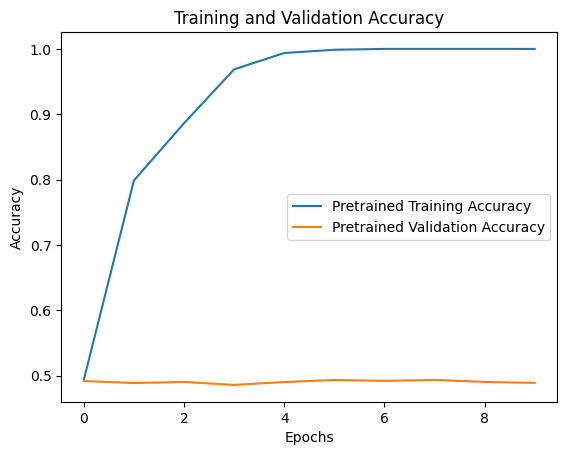

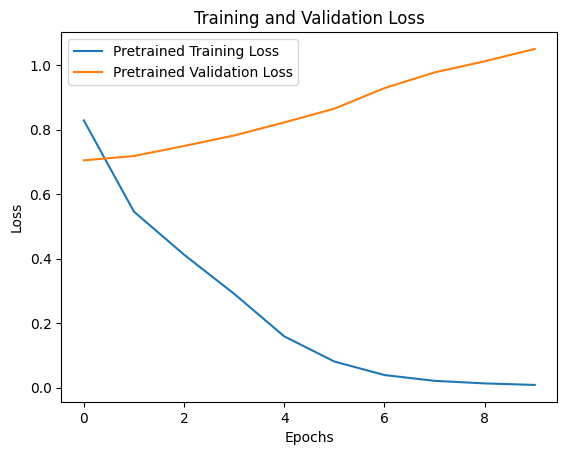

In [18]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 800  # training on 100 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)




# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

pretrained_model = Sequential()
pretrained_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
pretrained_model.add(Flatten())
pretrained_model.add(Dense(32, activation='relu'))
pretrained_model.add(Dense(1, activation='sigmoid'))
pretrained_model.summary()

# Compiling the model
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Setting pre-trained GloVe embeddings
pretrained_model.layers[0].set_weights([embedding_matrix])
pretrained_model.layers[0].trainable = False

# Training the model
pretrained_history = pretrained_model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
accuracy = pretrained_history.history['acc']
valid_accuracy = pretrained_history.history['val_acc']
train_loss = pretrained_history.history['loss']
valid_loss = pretrained_history.history['val_loss']

test_loss, test_accuracy = pretrained_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)
plt.plot(pretrained_history.history['acc'], label='Pretrained Training Accuracy')
plt.plot(pretrained_history.history['val_acc'], label='Pretrained Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(pretrained_history.history['loss'], label='Pretrained Training Loss')
plt.plot(pretrained_history.history['val_loss'], label='Pretrained Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


4. Training Samples 5000

**Embedding Layer**

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_5 (Flatten)         (None, 1200)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81201 (317.19 KB)
Trainable params: 81201 (317.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
125/125 [==============================] - 2s 13ms/step - loss: 0.6923 - acc: 0.5110 - val_loss: 0.6896 - val_acc: 0.5320
Epoch 2/10
125/125 [==============================] - 2s 15ms/step - loss: 0.6564 - acc: 0.7730 - val_loss: 0.6613 - val_acc: 0.7000
Epoch 3/10
125

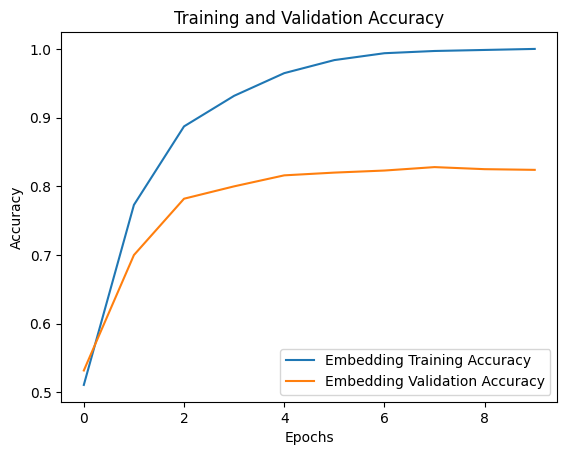

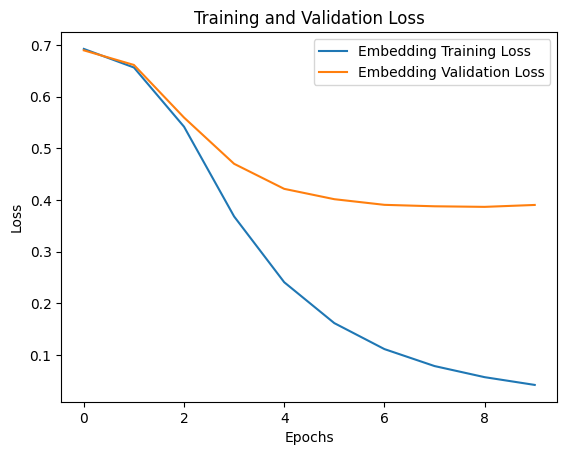

In [14]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM

# Set parameters
max_features = 10000  # Consider only the top 10,000 words
maxlen = 150  # Cutoff reviews after 150 words
train_samples = 5000  # Restrict training samples to 100
validation_samples = 10000  # Number of samples for validation

# Load IMDb dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Preprocess the data
x_train = pad_sequences(x_train[:train_samples], maxlen=maxlen)
y_train = np.array(y_train[:train_samples])
x_test = pad_sequences(x_test, maxlen=maxlen)
y_test = np.array(y_test)
# Define model with embedding layer
embedding_model = Sequential([
    Embedding(max_features, 8 , input_length=maxlen),
    Flatten(),
    Dense(1, activation='sigmoid')
])
embedding_model.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['acc'])
embedding_model.summary()



# Train embedding model
embedding_history = embedding_model.fit(x_train, y_train,
                                            epochs=10,
                                            batch_size=32,
                                            validation_split=0.2)


train_accuracy = embedding_history.history['acc']
val_accuracy = embedding_history.history['val_acc']
loss = embedding_history.history["loss"]
val_loss = embedding_history.history["val_loss"]
test_loss, test_accuracy = embedding_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)
plt.plot(embedding_history.history['acc'], label='Embedding Training Accuracy')
plt.plot(embedding_history.history['val_acc'], label='Embedding Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(embedding_history.history['loss'], label='Embedding Training Loss')
plt.plot(embedding_history.history['val_loss'], label='Embedding Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





**Pre-Trained Model**

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 flatten_9 (Flatten)         (None, 15000)             0         
                                                                 
 dense_12 (Dense)            (None, 32)                480032    
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1480065 (5.65 MB)
Trainable params: 1480065 (5.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 

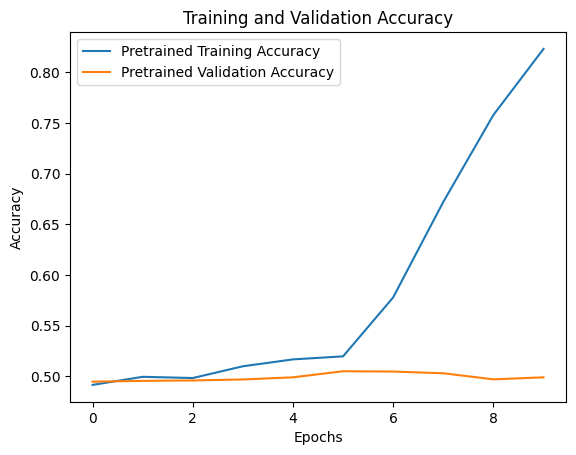

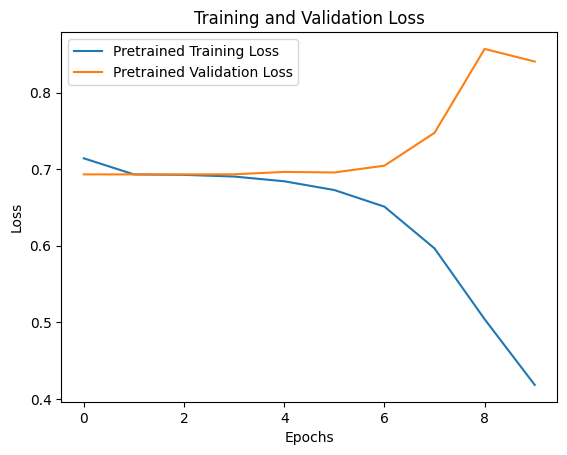

In [19]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 5000  # training on 100 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)




# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

pretrained_model = Sequential()
pretrained_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
pretrained_model.add(Flatten())
pretrained_model.add(Dense(32, activation='relu'))
pretrained_model.add(Dense(1, activation='sigmoid'))
pretrained_model.summary()

# Compiling the model
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Setting pre-trained GloVe embeddings
pretrained_model.layers[0].set_weights([embedding_matrix])
pretrained_model.layers[0].trainable = False

# Training the model
pretrained_history = pretrained_model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
accuracy = pretrained_history.history['acc']
valid_accuracy = pretrained_history.history['val_acc']
train_loss = pretrained_history.history['loss']
valid_loss = pretrained_history.history['val_loss']

test_loss, test_accuracy = pretrained_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)
plt.plot(pretrained_history.history['acc'], label='Pretrained Training Accuracy')
plt.plot(pretrained_history.history['val_acc'], label='Pretrained Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(pretrained_history.history['loss'], label='Pretrained Training Loss')
plt.plot(pretrained_history.history['val_loss'], label='Pretrained Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

5. Training Samples 10000

**Embedding Layer**

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_6 (Flatten)         (None, 1200)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81201 (317.19 KB)
Trainable params: 81201 (317.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 3s 9ms/step - loss: 0.6851 - acc: 0.5670 - val_loss: 0.6517 - val_acc: 0.7225
Epoch 2/10
250/250 [==============================] - 2s 6ms/step - loss: 0.5120 - acc: 0.8275 - val_loss: 0.4247 - val_acc: 0.8395
Epoch 3/10
250/2

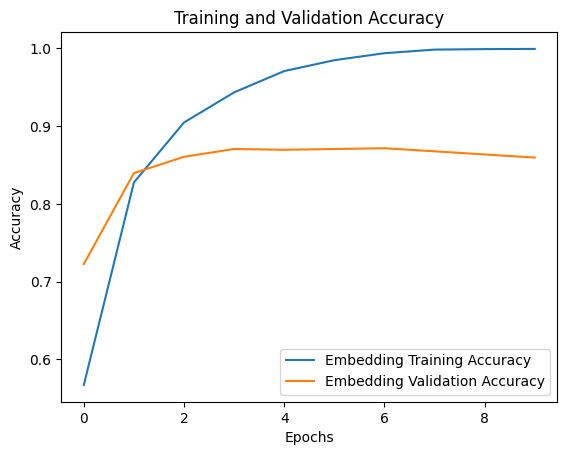

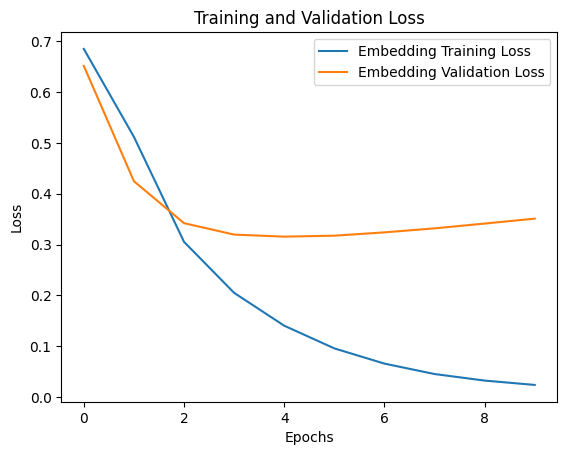

In [15]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM

# Set parameters
max_features = 10000  # Consider only the top 10,000 words
maxlen = 150  # Cutoff reviews after 150 words
train_samples = 10000  # Restrict training samples to 100
validation_samples = 10000  # Number of samples for validation

# Load IMDb dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Preprocess the data
x_train = pad_sequences(x_train[:train_samples], maxlen=maxlen)
y_train = np.array(y_train[:train_samples])
x_test = pad_sequences(x_test, maxlen=maxlen)
y_test = np.array(y_test)
# Define model with embedding layer
embedding_model = Sequential([
    Embedding(max_features, 8 , input_length=maxlen),
    Flatten(),
    Dense(1, activation='sigmoid')
])
embedding_model.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['acc'])
embedding_model.summary()



# Train embedding model
embedding_history = embedding_model.fit(x_train, y_train,
                                            epochs=10,
                                            batch_size=32,
                                            validation_split=0.2)


train_accuracy = embedding_history.history['acc']
val_accuracy = embedding_history.history['val_acc']
loss = embedding_history.history["loss"]
val_loss = embedding_history.history["val_loss"]
test_loss, test_accuracy = embedding_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)
plt.plot(embedding_history.history['acc'], label='Embedding Training Accuracy')
plt.plot(embedding_history.history['val_acc'], label='Embedding Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(embedding_history.history['loss'], label='Embedding Training Loss')
plt.plot(embedding_history.history['val_loss'], label='Embedding Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Pre-Trained Model**

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 100)          1000000   
                                                                 
 flatten_10 (Flatten)        (None, 15000)             0         
                                                                 
 dense_14 (Dense)            (None, 32)                480032    
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1480065 (5.65 MB)
Trainable params: 1480065 (5.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
313/313 [==============================] -

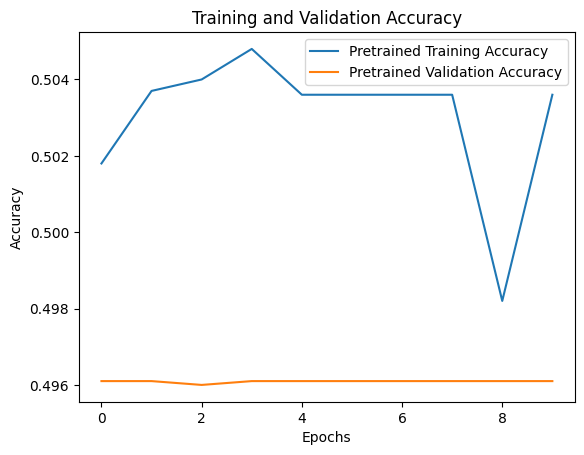

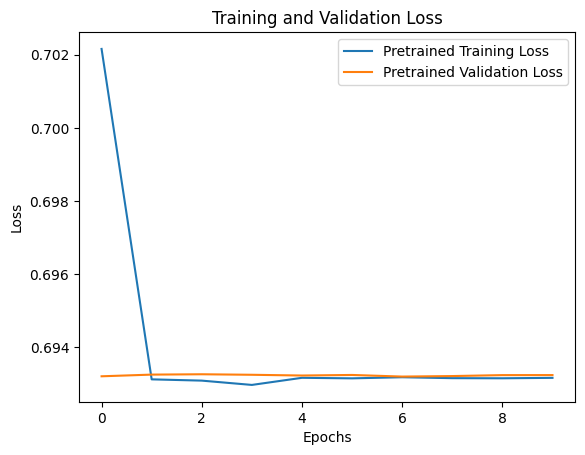

In [20]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 10000  # training on 100 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)




# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

pretrained_model = Sequential()
pretrained_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
pretrained_model.add(Flatten())
pretrained_model.add(Dense(32, activation='relu'))
pretrained_model.add(Dense(1, activation='sigmoid'))
pretrained_model.summary()

# Compiling the model
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Setting pre-trained GloVe embeddings
pretrained_model.layers[0].set_weights([embedding_matrix])
pretrained_model.layers[0].trainable = False

# Training the model
pretrained_history = pretrained_model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
accuracy = pretrained_history.history['acc']
valid_accuracy = pretrained_history.history['val_acc']
train_loss = pretrained_history.history['loss']
valid_loss = pretrained_history.history['val_loss']

test_loss, test_accuracy = pretrained_model.evaluate(x_test, y_test)
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', val_accuracy)
print('Test Loss:', test_loss)
print('Test Embedding Accuracy:', test_accuracy)
plt.plot(pretrained_history.history['acc'], label='Pretrained Training Accuracy')
plt.plot(pretrained_history.history['val_acc'], label='Pretrained Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(pretrained_history.history['loss'], label='Pretrained Training Loss')
plt.plot(pretrained_history.history['val_loss'], label='Pretrained Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy caomparision for training samples

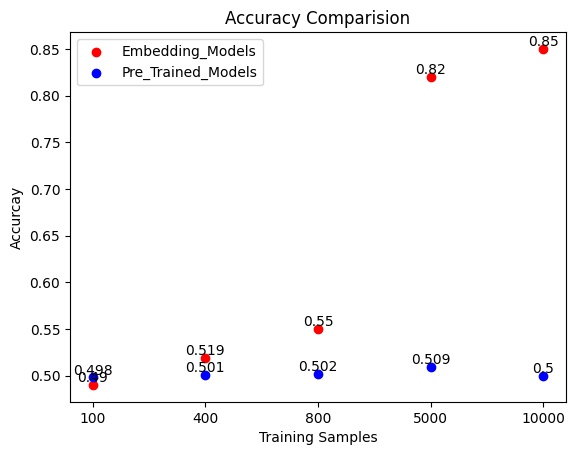

In [26]:
Embedding_Models = ("100","400","800","5000","10000")
Pre_Trained_Models=("100","400","800","5000","10000")

Embedding_Accuracy = (0.49,0.519,0.55,0.82,0.85)


Pre_Trained_Accuracy= (0.498,0.501,0.502,0.509,0.5 )

# Accuracy
plt.scatter(Embedding_Models, Embedding_Accuracy, color="red",
            label= 'Embedding_Models' )

plt.scatter(Pre_Trained_Models, Pre_Trained_Accuracy, color="Blue",
            label='Pre_Trained_Models' )

plt.title("Accuracy Comparision")
plt.xlabel("Training Samples")
plt.ylabel("Accurcay")
plt.legend()

for (xi, yi) in zip(Embedding_Models,Embedding_Accuracy):
    plt.text(xi, yi, yi, va='bottom', ha='center')

for (xi, yi) in zip(Pre_Trained_Models,Pre_Trained_Accuracy):
    plt.text(xi, yi, yi, va='bottom', ha='center')
plt.show()

From the analysis
For Embedding Models:
Performance increases with the increase in training sample size, with the highest accuracy achieved with an training sample size of 10000.

For Pre-Trained Models:

Accuracy remains relatively stable across different pre-trained model sizes, with no significant improvement observed

Embedding Models vs. Pre-Trained Models:

Embedding models generally outperform pre-trained models across all training sample sizes tested.
Embedding models show a more significant improvement in accuracy with larger training sample sizes compared to pre-trained models.


In summary, when considering accuracy and performance, embedding models, particularly those with larger sizes, outperform pre-trained models for the given task. However, it's essential to balance computational resources with performance gains, especially when working with very large training sample  sizes.
